### **Исследование методов классификации изображений рукописных цифр с помощью полносвязной нейронной сети**

**Выполнил:** Скоробогатов Кирилл, ИСТ-032м

**Задача**
1.	Исследовать нейронную сеть при заданных начальных параметрах (см. таблицу).
2.	Исследовать зависимость точности распознавания от количества нейронов в скрытом слое, количества слоев, метода активации.
3.	Замерить время вычисления 100 эпох на CPU и на GPU. 
4.	Построить на одном графике loss для train и test. Зафиксировать имеется ли переобучение сети


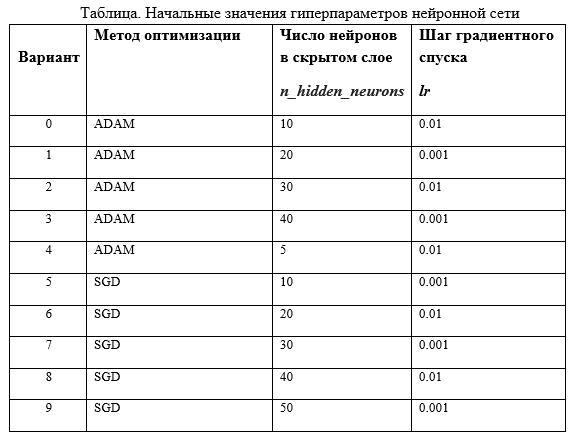

In [ ]:
#y_accuracy_neurons = []
#y_accuracy_activation_functions = []
y_accuracy_hidden_layers = []

In [ ]:
import torch
import random
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
import warnings
import time

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True


warnings.filterwarnings('ignore')

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

In [ ]:
X_train = torch.tensor(X_train)
y_train = torch.LongTensor(y_train)
X_test = torch.tensor(X_test)
y_test = torch.LongTensor(y_test)

In [ ]:
X_train.shape, y_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000]))

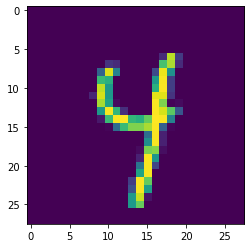

tensor(4)


In [ ]:
plt.imshow(X_train[26].reshape(28,28))
plt.show()
print(y_train[26])

In [ ]:
#расиягивание картинки в один длинный вектор
X_train = X_train.reshape([-1, 28 * 28])
X_test = X_test.reshape([-1, 28 * 28])

In [ ]:
#[1, 5, 10, 20, 40, 80, 160, 320]
n_neurons = 10
lr=0.01
batch_size = 128
n_epoch = 100
optimizer_method = 'Adam'
#optimizer_method = 'SGD'

In [ ]:
# ['Sigmoid', 'Tanh', 'ReLU', 'SELU', 'CELU']

class MNISTNet(torch.nn.Module): 
    def __init__(self, n_hidden_neurons): 
        super(MNISTNet, self).__init__() 
        self.fc1 = torch.nn.Linear(784, n_hidden_neurons) 
        self.ac1 = torch.nn.Sigmoid() 

        # self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons) 
        # self.ac2 = torch.nn.Sigmoid() 

        # self.fc3 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons) 
        # self.ac3 = torch.nn.Sigmoid() 

        self.fc4 = torch.nn.Linear(n_hidden_neurons, 10) 
        self.af4 = torch.nn.Softmax()


    def forward(self, x): 
        x = self.fc1(x) 
        x = self.ac1(x) 
        # x = self.fc2(x) 
        # x = self.ac2(x) 
        # x = self.fc3(x) 
        # x = self.ac3(x) 
        x = self.fc4(x) 
        x = self.af4(x)
        return x 

In [ ]:
def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.xavier_normal(m.weight)
        m.bias.data.fill_(0.01)

mnist_net = MNISTNet(n_neurons)
mnist_net.apply(init_weights)

MNISTNet(
  (fc1): Linear(in_features=784, out_features=10, bias=True)
  (ac1): Sigmoid()
  (fc4): Linear(in_features=10, out_features=10, bias=True)
  (af4): Softmax(dim=None)
)

In [ ]:
torch.cuda.is_available()

False

In [ ]:
!nvidia-smi

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mnist_net = mnist_net.to(device)
list(mnist_net.parameters())


loss = torch.nn.CrossEntropyLoss()


if optimizer_method == 'Adam':
  optimizer = torch.optim.Adam(mnist_net.parameters(), lr=lr)
elif optimizer_method == 'SGD': 
  optimizer = torch.optim.SGD(mnist_net.parameters(), lr=lr)


NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
X_train.shape

torch.Size([60000, 784])

In [ ]:
test_accuracy_history = []
test_loss_history = []
train_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

start_time = time.time()
for epoch in range(n_epoch):
    order = np.random.permutation(len(X_train))
    train_batch_loss_history = [] 
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]  
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = mnist_net.forward(X_batch) 
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        train_batch_loss_history.append(loss_value.tolist()) 
        optimizer.step()

    test_preds = mnist_net.forward(X_test)
    
    #ошибка нейросети по тестовым данным
    test_loss = loss(test_preds, y_test)
    test_loss_history.append(test_loss.tolist())
    
    #подсчёт точности распознавания и запись ее в массив
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
    test_accuracy_history.append(accuracy.tolist())
    
    #ошибка нейросети по трейновому датасету
    train_loss = np.mean(train_batch_loss_history)
    train_loss_history.append(train_loss)
    
    # print('Количество эпох = {:2d} | tr_loss = {:.4f} | val_loss = {:.4f} | val_acc = {:.4f}'.format(
    #     epoch,
    #     train_loss,
    #     test_loss,
    #     accuracy.tolist()))
    
    print('Количество эпох = {:2d} | val_acc = {:.4f}'.format(
        epoch,
        accuracy.tolist()))
end_time = time.time()

# y_accuracy_neurons.append(np.mean(test_accuracy_history))
# y_accuracy_activation_functions.append(np.mean(test_accuracy_history))
# y_accuracy_hidden_layers.append(np.mean(test_accuracy_history))

print(f'Время обучения: {end_time - start_time} сек.')
print(f'test_loss_history = {test_loss_history}\n---------------------\ntrain_loss_history = {train_loss_history}')
# print(f'---------------------\ny_accuracy_neurons = {y_accuracy_neurons}')
# print(f'---------------------\ny_accuracy_activation_functions = {y_accuracy_activation_functions}')
# print(f'---------------------\ny_accuracy_hidden_layers = {y_accuracy_hidden_layers}')

Количество эпох =  0 | val_acc = 0.8977
Количество эпох =  1 | val_acc = 0.9117
Количество эпох =  2 | val_acc = 0.9184
Количество эпох =  3 | val_acc = 0.9213
Количество эпох =  4 | val_acc = 0.9220
Количество эпох =  5 | val_acc = 0.9249
Количество эпох =  6 | val_acc = 0.9266
Количество эпох =  7 | val_acc = 0.9233
Количество эпох =  8 | val_acc = 0.9185
Количество эпох =  9 | val_acc = 0.9246
Количество эпох = 10 | val_acc = 0.9251
Количество эпох = 11 | val_acc = 0.9286
Количество эпох = 12 | val_acc = 0.9282
Количество эпох = 13 | val_acc = 0.9198
Количество эпох = 14 | val_acc = 0.9274
Количество эпох = 15 | val_acc = 0.9276
Количество эпох = 16 | val_acc = 0.9252
Количество эпох = 17 | val_acc = 0.9255
Количество эпох = 18 | val_acc = 0.9231
Количество эпох = 19 | val_acc = 0.9285
Количество эпох = 20 | val_acc = 0.9278
Количество эпох = 21 | val_acc = 0.9260
Количество эпох = 22 | val_acc = 0.9280
Количество эпох = 23 | val_acc = 0.9298
Количество эпох = 24 | val_acc = 0.9252


### **График точности для тестовых данных**

[0.8977000117301941, 0.9117000102996826, 0.91839998960495, 0.9212999939918518, 0.921999990940094, 0.9248999953269958, 0.9265999794006348, 0.92330002784729, 0.9185000061988831, 0.9246000051498413, 0.9251000285148621, 0.928600013256073, 0.9282000064849854, 0.9197999835014343, 0.9273999929428101, 0.9276000261306763, 0.9251999855041504, 0.9254999756813049, 0.9230999946594238, 0.9284999966621399, 0.9277999997138977, 0.9259999990463257, 0.9279999732971191, 0.9297999739646912, 0.9251999855041504, 0.927299976348877, 0.9257000088691711, 0.9247000217437744, 0.9258000254631042, 0.9275000095367432, 0.9294000267982483, 0.9276000261306763, 0.9273999929428101, 0.9251000285148621, 0.9279999732971191, 0.9264000058174133, 0.9302999973297119, 0.9246000051498413, 0.9289000034332275, 0.9251000285148621, 0.9251999855041504, 0.9223999977111816, 0.928600013256073, 0.9271000027656555, 0.930899977684021, 0.9284999966621399, 0.9247000217437744, 0.925000011920929, 0.9266999959945679, 0.9269000291824341, 0.9276999

Text(0, 0.5, '\nТочность распознавания')

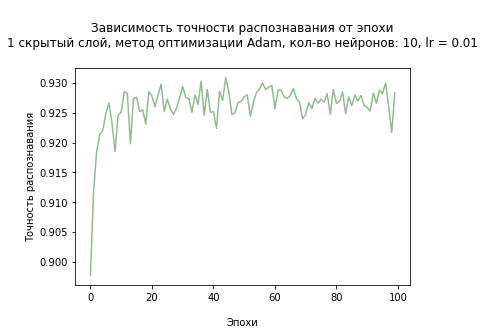

In [ ]:
print(test_accuracy_history)
test_accuracy_history_10_0_01= [0.8977000117301941, 0.9117000102996826, 0.91839998960495, 0.9212999939918518, 0.921999990940094, 0.9248999953269958, 0.9265999794006348, 0.92330002784729, 0.9185000061988831, 0.9246000051498413, 0.9251000285148621, 0.928600013256073, 0.9282000064849854, 0.9197999835014343, 0.9273999929428101, 0.9276000261306763, 0.9251999855041504, 0.9254999756813049, 0.9230999946594238, 0.9284999966621399, 0.9277999997138977, 0.9259999990463257, 0.9279999732971191, 0.9297999739646912, 0.9251999855041504, 0.927299976348877, 0.9257000088691711, 0.9247000217437744, 0.9258000254631042, 0.9275000095367432, 0.9294000267982483, 0.9276000261306763, 0.9273999929428101, 0.9251000285148621, 0.9279999732971191, 0.9264000058174133, 0.9302999973297119, 0.9246000051498413, 0.9289000034332275, 0.9251000285148621, 0.9251999855041504, 0.9223999977111816, 0.928600013256073, 0.9271000027656555, 0.930899977684021, 0.9284999966621399, 0.9247000217437744, 0.925000011920929, 0.9266999959945679, 0.9269000291824341, 0.9276999831199646, 0.9279999732971191, 0.9243999719619751, 0.9266999959945679, 0.9283999800682068, 0.9290000200271606, 0.9300000071525574, 0.9289000034332275, 0.9293000102043152, 0.9296000003814697, 0.9257000088691711, 0.9287999868392944, 0.9287999868392944, 0.9276999831199646, 0.9273999929428101, 0.9279000163078308, 0.929099977016449, 0.9273999929428101, 0.926800012588501, 0.9240000247955322, 0.9247000217437744, 0.9266999959945679, 0.9257000088691711, 0.9273999929428101, 0.9265999794006348, 0.927299976348877, 0.926800012588501, 0.9282000064849854, 0.9247000217437744, 0.9289000034332275, 0.9265999794006348, 0.9269000291824341, 0.9284999966621399, 0.9248999953269958, 0.9276999831199646, 0.9261999726295471, 0.9279999732971191, 0.9269999861717224, 0.9279000163078308, 0.9261999726295471, 0.9258999824523926, 0.9253000020980835, 0.9283000230789185, 0.9265999794006348, 0.9287999868392944, 0.9282000064849854, 0.9300000071525574, 0.9259999990463257, 0.9217000007629395, 0.9283999800682068]
#test_accuracy_history_10_0_001= [0.6407999992370605, 0.6556000113487244, 0.7433000206947327, 0.7488999962806702, 0.7523999810218811, 0.7797999978065491, 0.8325999975204468, 0.8985000252723694, 0.9064000248908997, 0.9124000072479248, 0.9133999943733215, 0.9156000018119812, 0.9171000123023987, 0.9180999994277954, 0.9207000136375427, 0.9200000166893005, 0.9214000105857849, 0.9212999939918518, 0.923799991607666, 0.9225999712944031, 0.9241999983787537, 0.9235000014305115, 0.925000011920929, 0.9244999885559082, 0.9254000186920166, 0.925000011920929, 0.9262999892234802, 0.9261999726295471, 0.9265000224113464, 0.926800012588501, 0.9279000163078308, 0.9300000071525574, 0.9280999898910522, 0.9275000095367432, 0.9297000169754028, 0.9284999966621399, 0.9297000169754028, 0.9297000169754028, 0.9297999739646912, 0.9297999739646912, 0.9300000071525574, 0.9301999807357788, 0.930899977684021, 0.930400013923645, 0.9311000108718872, 0.9289000034332275, 0.9309999942779541, 0.9311000108718872, 0.9297999739646912, 0.9308000206947327, 0.9312000274658203, 0.9304999709129333, 0.9307000041007996, 0.9315000176429749, 0.930899977684021, 0.9312000274658203, 0.9315000176429749, 0.9312999844551086, 0.9302999973297119, 0.9312999844551086, 0.930899977684021, 0.9301999807357788, 0.9296000003814697, 0.9305999875068665, 0.9312000274658203, 0.9312999844551086, 0.9312000274658203, 0.9307000041007996, 0.9305999875068665, 0.9316999912261963, 0.9307000041007996, 0.9316999912261963, 0.930400013923645, 0.930899977684021, 0.9320999979972839, 0.9307000041007996, 0.9309999942779541, 0.9315000176429749, 0.9319000244140625, 0.9314000010490417, 0.9318000078201294, 0.9315999746322632, 0.9323999881744385, 0.930899977684021, 0.9315000176429749, 0.9307000041007996, 0.9311000108718872, 0.9314000010490417, 0.9315999746322632, 0.9325000047683716, 0.9315000176429749, 0.9319999814033508, 0.9312000274658203, 0.9318000078201294, 0.9318000078201294, 0.9312999844551086, 0.9315000176429749, 0.9304999709129333, 0.9312000274658203, 0.9309999942779541]

plt.plot([i for i in range(0, n_epoch)], test_accuracy_history_10_0_01, color='darkseagreen')
#plt.plot([i for i in range(0, n_epoch)], test_accuracy_history_10_0_001, color='darkturquoise', label ='lr=0.001')
plt.title(f'\nЗависимость точности распознавания от эпохи\n1 скрытый слой, метод оптимизации Adam, кол-во нейронов: {n_neurons}, lr = {lr}\n')
plt.xlabel('\nЭпохи') 
plt.ylabel('\nТочность распознавания')


### **Зависимость точности распознавания от количества нейронов в скрытом слое**

Text(0, 0.5, 'Точность распознавания')

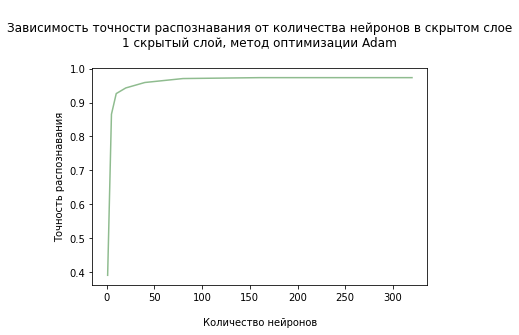

In [ ]:
x_neurons = [1, 5, 10, 20, 40, 80, 160, 320]
y_accuracy_neurons = [0.3907749892771244, 0.8655309802293778, 0.9264079761505127, 0.9430459779500961, 0.9590969747304916, 0.9707289749383926, 0.9733809745311737, 0.9733989757299423]

plt.plot(x_neurons, y_accuracy_neurons, color='darkseagreen')
plt.title('\nЗависимость точности распознавания от количества нейронов в скрытом слое\n1 скрытый слой, метод оптимизации Adam\n')
plt.xlabel('\nКоличество нейронов')
plt.ylabel('Точность распознавания')




### **Зависимость точности распознавания от количества количества слоев**

[0.9261629992723465, 0.9286769992113113, 0.9163850003480911]


Text(0, 0.5, 'Точность распознавания\n')

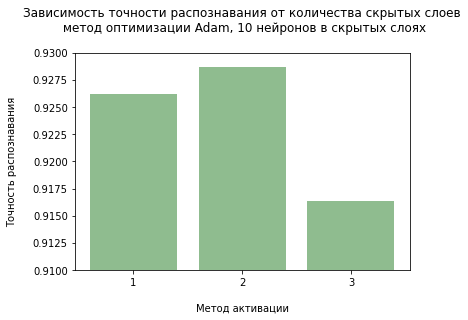

In [ ]:
x_hidden_layers = ['1', '2', '3']
y_accuracy_hidden_layers = [0.9261629992723465, 0.9286769992113113, 0.9163850003480911]

print(y_accuracy_hidden_layers)

fig, ax1 = plt.subplots()
ax1.set_ylim(0.91, 0.93)

ax1.title.set_text('Зависимость точности распознавания от количества скрытых слоев\n метод оптимизации Adam, 10 нейронов в скрытых слоях\n')
ax1.bar(x_hidden_layers, y_accuracy_hidden_layers, color='darkseagreen')
ax1.set_xlabel('\nМетод активации')
ax1.set_ylabel('Точность распознавания\n')


### **Зависимость точности распознавания от метода активации**

[0.9707539761066437, 0.9618009722232819, 0.964549977183342, 0.963975973725319, 0.965946974158287]


Text(0, 0.5, 'Точность распознавания\n')

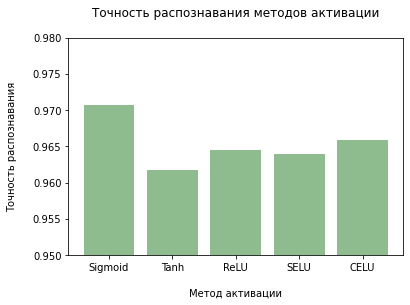

In [ ]:
x_activation_functions = ['Sigmoid', 'Tanh', 'ReLU', 'SELU', 'CELU']
y_accuracy_activation_functions = [0.9707539761066437, 0.9618009722232819, 0.964549977183342, 0.963975973725319, 0.965946974158287]


# plt.plot(x_neurons, y_accuracy_neurons)
# plt.title('Зависимость точности распознавания от метода активации\n1 скрытый слой, 100 нейронов в скрытом слое')
# plt.xlabel('\nФункции активации')
# plt.ylabel('Точность распознавания')

print(y_accuracy_activation_functions)

fig, ax1 = plt.subplots()
ax1.set_ylim(0.95, 0.98)

ax1.title.set_text('Точность распознавания методов активации\n')
ax1.bar(x_activation_functions, y_accuracy_activation_functions, color='darkseagreen')
ax1.set_xlabel('\nМетод активации')
ax1.set_ylabel('Точность распознавания\n')

### **CPU vs GPU**

In [ ]:
#print(f'гиперпараметры: lr={lr} num_of_neurons={n_neurons} num_of_epoch={n_epoch} optimizer_method={optimizer_method} batch_size={batch_size}')
#гиперпараметры: lr=0.01 num_of_neurons=256 num_of_epoch=100 optimizer_method=Adam batch_size=128

#time in sec. CPU, GPU
time_cpu_256_neurons = 595.5672688484192 #sec.
time_gpu_256_neurons = 106.80229759216309 #sec.

#print(f'гиперпараметры: lr={lr} num_of_neurons={n_neurons} num_of_epoch={n_epoch} optimizer_method={optimizer_method} batch_size={batch_size}')
#гиперпараметры: lr=0.01 num_of_neurons=10 num_of_epoch=100 optimizer_method=Adam batch_size=128

#time in sec. CPU, GPU
time_cpu_10_neurons = 60.75269079208374   #sec.
time_gpu_10_neurons = 106.69569087028503  #sec.


print(f'time_cpu_256_neurons = {time_cpu_256_neurons} сек. или {time_cpu_256_neurons/60} мин.')
print(f'time_gpu_256_neurons = {time_gpu_256_neurons} сек. или {time_gpu_256_neurons/60} мин.')
print(f'time_cpu_10_neurons  = {time_cpu_10_neurons} сек. или {time_cpu_10_neurons/60} мин.')
print(f'time_gpu_10_neurons  = {time_gpu_10_neurons} сек. или {time_gpu_10_neurons/60} мин.')


time_cpu_256_neurons = 595.5672688484192 сек. или 9.926121147473653 мин.
time_gpu_256_neurons = 106.80229759216309 сек. или 1.7800382932027181 мин.
time_cpu_10_neurons  = 60.75269079208374 сек. или 1.012544846534729 мин.
time_gpu_10_neurons  = 106.69569087028503 сек. или 1.7782615145047507 мин.


### **test_loss_history & train_loss_history**

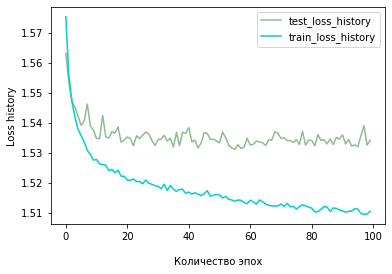

In [ ]:
x_epoch = [i for i in range(0, n_epoch)]
y_test_loss_history = [1.5631300210952759, 1.5534448623657227, 1.5470671653747559, 1.545225739479065, 1.5421793460845947, 1.5391610860824585, 1.5407495498657227, 1.5462619066238403, 1.5390313863754272, 1.5375555753707886, 1.5347614288330078, 1.5347709655761719, 1.5424816608428955, 1.5353749990463257, 1.5349475145339966, 1.5370831489562988, 1.5365750789642334, 1.5386593341827393, 1.5335521697998047, 1.5342507362365723, 1.535287618637085, 1.5348533391952515, 1.5323512554168701, 1.5356932878494263, 1.5347667932510376, 1.5358549356460571, 1.5369774103164673, 1.5362954139709473, 1.5341542959213257, 1.532459020614624, 1.5344220399856567, 1.534576177597046, 1.53584623336792, 1.5339604616165161, 1.5349031686782837, 1.5319042205810547, 1.5368170738220215, 1.5324164628982544, 1.5368787050247192, 1.5364913940429688, 1.5383683443069458, 1.5336694717407227, 1.5342395305633545, 1.5316370725631714, 1.5332233905792236, 1.5366990566253662, 1.536502480506897, 1.53457510471344, 1.534561038017273, 1.5339716672897339, 1.53334641456604, 1.5368729829788208, 1.5351303815841675, 1.5324914455413818, 1.5316627025604248, 1.5312221050262451, 1.5327374935150146, 1.531480312347412, 1.5319373607635498, 1.534915566444397, 1.532623291015625, 1.5328490734100342, 1.5339442491531372, 1.5336432456970215, 1.5334051847457886, 1.5324500799179077, 1.534332275390625, 1.5342597961425781, 1.5370036363601685, 1.5365500450134277, 1.5348173379898071, 1.5350418090820312, 1.5340651273727417, 1.5341359376907349, 1.5334993600845337, 1.5344504117965698, 1.5328468084335327, 1.5371668338775635, 1.532608985900879, 1.5342761278152466, 1.5341362953186035, 1.5323607921600342, 1.5361067056655884, 1.5341709852218628, 1.5343987941741943, 1.5329746007919312, 1.5346567630767822, 1.532789707183838, 1.5351483821868896, 1.5345773696899414, 1.5360461473464966, 1.5329909324645996, 1.534484624862671, 1.5322035551071167, 1.5326800346374512, 1.5320693254470825, 1.535690188407898, 1.5390499830245972, 1.532590389251709, 1.5342527627944946]
y_train_loss_history = [1.575329403633248, 1.5556092745205488, 1.5471453839527773, 1.5418128987619364, 1.5377767352915521, 1.5357545413442257, 1.5335609401975359, 1.5308845332944825, 1.529413539463523, 1.5276026611389129, 1.527832997633196, 1.5263632182627598, 1.5260802919168208, 1.5259377242151353, 1.5241322982540009, 1.5245054784868317, 1.5234368559139877, 1.5242247123962271, 1.5222577263297303, 1.5222247508543132, 1.520944272531375, 1.5208828822890323, 1.5213582055655115, 1.5204788304086942, 1.5204685217281904, 1.519732177130449, 1.5209727958321317, 1.5199203231949796, 1.5195598175276572, 1.5190701756650196, 1.5188953113962593, 1.5180921419851308, 1.5195672982282984, 1.5175142229747163, 1.5191779413711288, 1.517894806129846, 1.5171868740114323, 1.5178532852038646, 1.5178853453857812, 1.516518163274346, 1.5169903588955844, 1.5163276429369505, 1.5167150863452252, 1.5162967463800394, 1.5157915013177055, 1.5164201826429062, 1.5174285267461847, 1.5156052638726956, 1.515898532704758, 1.5161842171317224, 1.5160168378846224, 1.5150545804993685, 1.5155288090329688, 1.5145362602876449, 1.5143452656548668, 1.5139015104724909, 1.5143337076915098, 1.5142252389301878, 1.5135077016948382, 1.513108898835904, 1.5142820092406608, 1.5136637453839723, 1.5129780105944635, 1.5143414278274405, 1.5137618070980634, 1.5130161799347477, 1.5125765259077808, 1.5123744931048169, 1.512292810848781, 1.5123897940873592, 1.5130097012021648, 1.512161612002326, 1.5132391653589603, 1.5120901253177668, 1.51222893805392, 1.5113148839234798, 1.5121079218158844, 1.5127721811408428, 1.51232455864644, 1.5119914390893379, 1.5115933395397942, 1.5103777146288582, 1.5104456578236398, 1.5112666997319855, 1.51213226084516, 1.5120031632848385, 1.5105114712643979, 1.5117024226483506, 1.511536317847685, 1.5110049855226138, 1.5107303212192267, 1.5102979310794171, 1.5105514724625708, 1.5106461782699454, 1.511417466186003, 1.5113209079323546, 1.509808992017815, 1.509572135360002, 1.5096615893500192, 1.5105836653251892]


fig, ax1 = plt.subplots()
ax1.plot(x_epoch, y_test_loss_history, label = 'test_loss_history', color='darkseagreen')
ax1.plot(x_epoch, y_train_loss_history, label = 'train_loss_history', color='darkturquoise')
ax1.set_xlabel('\nКоличество эпох')
ax1.set_ylabel('Loss history')
ax1.legend()

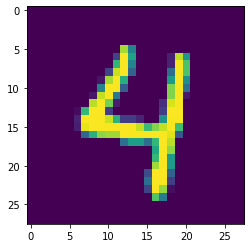

------------------
Прогноз модели: 4 
------------------



In [ ]:
X_to_predict = X_test[27]
###########
predicted_number = mnist_net.forward(X_to_predict).detach().numpy()
plt.imshow(X_to_predict.reshape(28,28))
plt.show()
print("------------------\nПрогноз модели: {} \n------------------\n".format(
    np.argmax(predicted_number)) 
)

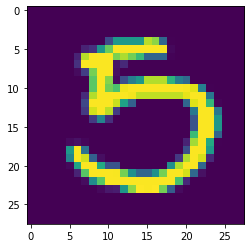

------------------
Прогноз модели: 0 
------------------



In [ ]:
X_to_predict = X_test[352]
###########
predicted_number = mnist_net.forward(X_to_predict).detach().numpy()
plt.imshow(X_to_predict.reshape(28,28))
plt.show()
print("------------------\nПрогноз модели: {} \n------------------\n".format(
    np.argmax(predicted_number)) 
)

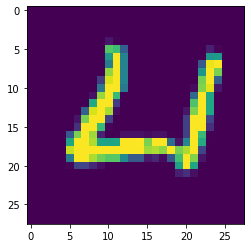

------------------
Прогноз модели: 4 
------------------



In [ ]:
X_to_predict = X_test[33]
###########
predicted_number = mnist_net.forward(X_to_predict).detach().numpy()
plt.imshow(X_to_predict.reshape(28,28))
plt.show()
print("------------------\nПрогноз модели: {} \n------------------\n".format(
    np.argmax(predicted_number)) 
)